In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from datetime import datetime

# Configure matplotlib for LaTeX rendering
plt.rcParams.update({
    'text.usetex': False,  # Disable LaTeX to use system fonts
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],  # Impact first, fallbacks
    'font.size': 20,
    'axes.labelsize': 25,
    'axes.titlesize': 25,
    'legend.fontsize': 25,
    'xtick.labelsize': 30,
    'ytick.labelsize': 30,
    'figure.titlesize': 30,
    'pgf.rcfonts': False,  # Use LaTeX default fonts for PGF
    'pgf.preamble': r'\usepackage{amsmath}\usepackage{amsfonts}'
})

from plot.multicurve import MultiCurvePlotter
from plot.log_dual_plot import LogDualPlot

from core.nodes.transmission_node import TransmissionNode
from core.nodes.computing_node import ComputingNode

# Complete Offloading

- No computing on User Satellite in Offloading case
- Variation of $\phi_\text{ec}$
- Ratio $S_\text{isl} / S_\text{gl}$

In [37]:
with_legend = True
plot_precision = 1000

data_size = 100
phi_min = 0.0  # Minimum phi value
phi_max = 1.5  # Maximum phi value


In [38]:
config = {
    "base": {
        "obdh": {
            "speed": 30.0,
            "phi": 0.9,
            "energy_uptime": 1,
            "energy_io": 0.001
        },
        "ground_link": {
            "speed": 10.0,
            "energy": 5,
            "distance": 700
        }
    },
    "offloading": {
        "user_satellite": {
            "obdh": { # No computing on the user satellite in this scenario
                "phi": None,
                "speed": None,
                "energy_uptime": None,
                "energy_io": None
            },
            "isl": {
                "speed": None, # Exploring ISL speed variation
                "energy": 3,
                "distance": 100
            }
        },
        "edge_node": {
            "edge_computer": {
                "phi": None, # Exploring EC phi variation
                "speed": 300.0,
                "energy_uptime": 50,
                "energy_io": 0.001
            },
            "ground_link": {
                "speed": None, # Exploring GL speed variation
                "energy": 5,
                "distance": 700
            }
        }
    }
}

# Base Case

- Computing on User Satellite (OBDH)
- Ground Link

In [39]:
base_obdh_speed = config['base']['obdh']['speed']
base_odbh_phi = config['base']['obdh']['phi']
base_obdh_energy_uptime = config['base']['obdh']['energy_uptime']
base_obdh_energy_io = config['base']['obdh']['energy_io']

# Base Case - calculate reference costs
base_time_cost = 0
base_energy_cost = 0

obc = ComputingNode(
    speed=base_obdh_speed,
    phi=base_odbh_phi
)

base_time_cost += obc.time_cost(data_size)
base_energy_cost += obc.energy_cost(
    data_size,
    energy_uptime=base_obdh_energy_uptime,
    energy_io=base_obdh_energy_io
)

d_out_obc = obc.process(data_size)

base_ground_link_speed = config['base']['ground_link']['speed']
base_ground_link_energy = config['base']['ground_link']['energy']
base_ground_link_distance = config['base']['ground_link']['distance']

ground_link = TransmissionNode(
    speed=base_ground_link_speed
)

base_time_cost += ground_link.time_cost(d_out_obc)
base_energy_cost += ground_link.energy_cost(
    d_out_obc,
    energy=base_ground_link_energy,
    distance=base_ground_link_distance
)

print(f"Base case - Time: {base_time_cost:.3f}s, Energy: {base_energy_cost:.3f}J")

Base case - Time: 12.333s, Energy: 131.463J


In [40]:
n_satellites = range(1, 11, 1)
phi_en = 0.5
s_isl = base_ground_link_speed * 3
print(f"N satelites : {n_satellites}")
print(f"s_isl : {s_isl}")

N satelites : range(1, 11)
s_isl : 30.0


# Offloading Case

- No computing on User Satellite
- ISL to Edge Node
- Computing on Edge Node
- Edge Node ground link

In [41]:
time_costs = []
energy_costs = []

# Variation of Usr ISL
# isl_speed = config['offloading']['user_satellite']['isl']['speed']
off_isl_energy = config['offloading']['user_satellite']['isl']['energy']
off_isl_distance = config['offloading']['user_satellite']['isl']['distance']

off_edge_computer_speed = config['offloading']['edge_node']['edge_computer']['speed']
# Variation of EC phi
# edge_computer_phi = config['offloading']['edge_node']['edge_computer']['phi']
off_edge_computer_energy_uptime = config['offloading']['edge_node']['edge_computer']['energy_uptime']
off_edge_computer_energy_io = config['offloading']['edge_node']['edge_computer']['energy_io']

# Variation of EN gl
# off_ground_link_speed = config['offloading']['edge_node']['ground_link']['speed']
off_ground_link_energy = config['offloading']['edge_node']['ground_link']['energy']
off_ground_link_distance = config['offloading']['edge_node']['ground_link']['distance']

print("Computing cost grid...")

# ISL transmission
isl = TransmissionNode(speed=float(s_isl))
after_isl_iteration_time_cost = isl.time_cost(data_size)
after_isl_iteration_energy_cost = isl.energy_cost(
    data_size,
    energy=off_isl_energy,
    distance=off_isl_distance
)

d_out_isl = isl.process(data_size)

for i, n in enumerate(n_satellites):
    print(f"Satellite {n}...")

    edge_computer = ComputingNode(
    speed=off_edge_computer_speed,
    phi=phi_en
    )

    iteration_time_cost = after_isl_iteration_time_cost + edge_computer.time_cost(d_out_isl)
    iteration_energy_cost = after_isl_iteration_energy_cost + edge_computer.energy_cost(
        d_out_isl,
        energy_uptime=off_edge_computer_energy_uptime,
        energy_io=off_edge_computer_energy_io
    )

    d_out_ec = edge_computer.process(d_out_isl)

    if n > 1:
        for _ in range(n-1):
            en_isl = TransmissionNode(speed=float(s_isl))
            iteration_time_cost += en_isl.time_cost(d_out_ec)
            iteration_energy_cost += en_isl.energy_cost(
                d_out_ec,
                energy=off_isl_energy,
                distance=off_isl_distance
            )

            d_out_ec = en_isl.process(d_out_ec)

            print(d_out_ec)

    # Ground link transmission (fixed speed)
    ground_link = TransmissionNode(speed=float(base_ground_link_speed))
    iteration_time_cost += ground_link.time_cost(d_out_ec)
    iteration_energy_cost += ground_link.energy_cost(
        d_out_ec,
        energy=off_ground_link_energy,
        distance=off_ground_link_distance
    )

    # Total costs
    time_costs.append(iteration_time_cost)
    energy_costs.append(iteration_energy_cost)

Computing cost grid...
Satellite 1...
Satellite 2...
50.0
Satellite 3...
50.0
50.0
Satellite 4...
50.0
50.0
50.0
Satellite 5...
50.0
50.0
50.0
50.0
Satellite 6...
50.0
50.0
50.0
50.0
50.0
Satellite 7...
50.0
50.0
50.0
50.0
50.0
50.0
Satellite 8...
50.0
50.0
50.0
50.0
50.0
50.0
50.0
Satellite 9...
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
Satellite 10...
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0


[8.666666666666668, 10.333333333333334, 12.0, 13.666666666666668, 15.333333333333334, 17.0, 18.666666666666664, 20.333333333333332, 22.0, 23.666666666666668]
[107.89411766702308, 117.89411766702308, 127.89411766702308, 137.89411766702307, 147.89411766702307, 157.89411766702307, 167.89411766702307, 177.89411766702307, 187.89411766702307, 197.89411766702307]


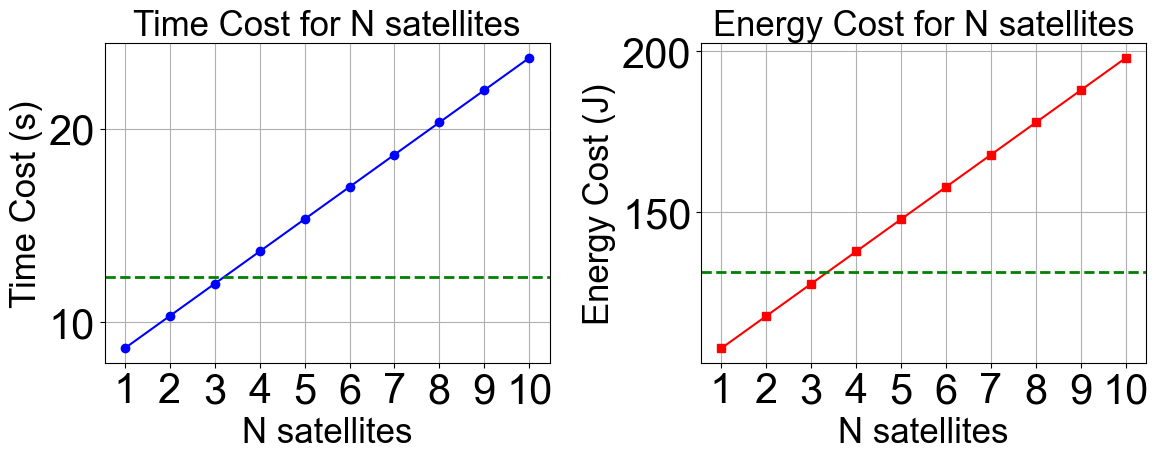

Results exported to script2_results.csv


In [42]:
print(time_costs)
print(energy_costs)

# Create a figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# First plot
ax1.plot(n_satellites, time_costs, marker='o', color='blue')
ax1.axhline(y=base_time_cost, color='green', linestyle='--', linewidth=2, label='Threshold')
ax1.set_xlabel('N satellites')
ax1.set_ylabel('Time Cost (s)')
ax1.set_title('Time Cost for N satellites')
ax1.set_xticks(n_satellites)
ax1.grid(True)

# Second plot
ax2.plot(n_satellites, energy_costs, marker='s', color='red')
ax2.axhline(y=base_energy_cost, color='green', linestyle='--', linewidth=2, label='Threshold')
ax2.set_xlabel('N satellites')
ax2.set_ylabel('Energy Cost (J)')
ax2.set_title('Energy Cost for N satellites')
ax2.set_xticks(n_satellites)
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

# Export results to CSV
df = pd.DataFrame({
    'n_satellites': n_satellites,
    'time_cost': time_costs,
    'energy_cost': energy_costs
})
df.to_csv('first_results.csv', index=False)
print("Results exported to script2_results.csv")

In [43]:
import matplotlib.pyplot as plt
import pandas as pd

n_satellites = 10
phi_en = 0.5

# Store costs per satellite
satellite_time_costs = []
satellite_energy_costs = []
satellite_numbers = []

# Configuration
off_isl_energy = config['offloading']['user_satellite']['isl']['energy']
off_isl_distance = config['offloading']['user_satellite']['isl']['distance']

off_edge_computer_speed = config['offloading']['edge_node']['edge_computer']['speed']
off_edge_computer_energy_uptime = config['offloading']['edge_node']['edge_computer']['energy_uptime']
off_edge_computer_energy_io = config['offloading']['edge_node']['edge_computer']['energy_io']

off_ground_link_energy = config['offloading']['edge_node']['ground_link']['energy']
off_ground_link_distance = config['offloading']['edge_node']['ground_link']['distance']

print("Computing cost per satellite (all computing on first satellite)...")

# Satellite 1: ISL + ALL Computing
print(f"Processing Satellite 1 (with all computing)...")

edge_computer = ComputingNode(
    speed=off_edge_computer_speed,
    phi=phi_en
)

ec_time_cost = edge_computer.time_cost(data_size)
ec_energy_cost = edge_computer.energy_cost(
    data_size,
    energy_uptime=off_edge_computer_energy_uptime,
    energy_io=off_edge_computer_energy_io
)

d_out = edge_computer.process(data_size)

isl = TransmissionNode(speed=float(s_isl))
isl_time_cost = isl.time_cost(d_out)
isl_energy_cost = isl.energy_cost(
    d_out,
    energy=off_isl_energy,
    distance=off_isl_distance
)

d_out = isl.process(d_out)

# Store costs for Satellite 1 (ISL + Computing)
sat1_time_cost = isl_time_cost + ec_time_cost
sat1_energy_cost = isl_energy_cost + ec_energy_cost

satellite_numbers.append(1)
satellite_time_costs.append(sat1_time_cost)
satellite_energy_costs.append(sat1_energy_cost)

print(f"Data size after computing: {d_out}")

# Satellites 2 to n-1: Only ISL transmissions (relay satellites)
for sat_num in range(2, n_satellites):
    print(f"Processing Satellite {sat_num} (relay only)...")

    isl = TransmissionNode(speed=float(s_isl))
    isl_time_cost = isl.time_cost(d_out)
    isl_energy_cost = isl.energy_cost(
        d_out,
        energy=off_isl_energy,
        distance=off_isl_distance
    )

    d_out = isl.process(d_out)

    # Store costs for relay satellite (only ISL)
    satellite_numbers.append(sat_num)
    satellite_time_costs.append(isl_time_cost)
    satellite_energy_costs.append(isl_energy_cost)

# Satellite n (last): ISL + Ground Link
print(f"Processing Satellite {n_satellites} (with ground link)...")

# Ground link transmission
ground_link = TransmissionNode(speed=float(base_ground_link_speed))
gl_time_cost = ground_link.time_cost(d_out)
gl_energy_cost = ground_link.energy_cost(
    d_out,
    energy=off_ground_link_energy,
    distance=off_ground_link_distance
)

satellite_numbers.append(n_satellites)
satellite_time_costs.append(gl_time_cost)
satellite_energy_costs.append(gl_energy_cost)

Computing cost per satellite (all computing on first satellite)...
Processing Satellite 1 (with all computing)...
Data size after computing: 50.0
Processing Satellite 2 (relay only)...
Processing Satellite 3 (relay only)...
Processing Satellite 4 (relay only)...
Processing Satellite 5 (relay only)...
Processing Satellite 6 (relay only)...
Processing Satellite 7 (relay only)...
Processing Satellite 8 (relay only)...
Processing Satellite 9 (relay only)...
Processing Satellite 10 (with ground link)...


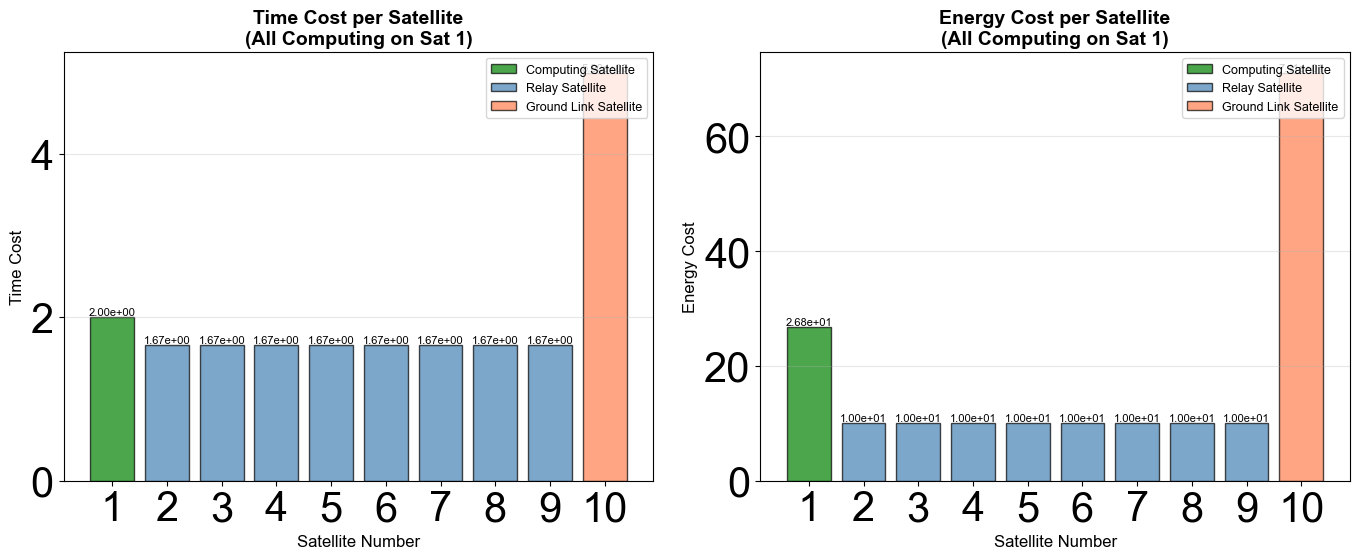


=== Per Satellite Cost Summary ===
Sat  Role                 Time Cost       Energy Cost    
------------------------------------------------------------
1    Computing            2.0000e+00      2.6767e+01     
2    Relay                1.6667e+00      1.0000e+01     
3    Relay                1.6667e+00      1.0000e+01     
4    Relay                1.6667e+00      1.0000e+01     
5    Relay                1.6667e+00      1.0000e+01     
6    Relay                1.6667e+00      1.0000e+01     
7    Relay                1.6667e+00      1.0000e+01     
8    Relay                1.6667e+00      1.0000e+01     
9    Relay                1.6667e+00      1.0000e+01     
10   Ground Link          5.0000e+00      7.1127e+01     

Total Time Cost: 2.0333e+01
Total Energy Cost: 1.7789e+02

=== Cost Distribution ===
Computing satellite (Sat 1) time cost: 2.0000e+00 (9.8%)
Relay satellites (Sat 2-9) avg time cost: 1.6667e+00
Ground link satellite (Sat 10) time cost: 5.0000e+00 (24.6%)


In [44]:
# Create plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Define colors for different satellite roles
colors = ['green'] + ['steelblue']*(n_satellites-2) + ['coral']

# Plot 1: Time Cost per Satellite
bars1 = ax1.bar(satellite_numbers, satellite_time_costs, color=colors, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Satellite Number', fontsize=12)
ax1.set_ylabel('Time Cost', fontsize=12)
ax1.set_title('Time Cost per Satellite\n(All Computing on Sat 1)', fontsize=14, fontweight='bold')
ax1.set_xticks(satellite_numbers)
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (sat, cost) in enumerate(zip(satellite_numbers, satellite_time_costs)):
    ax1.text(sat, cost, f'{cost:.2e}', ha='center', va='bottom', fontsize=8, rotation=0)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', alpha=0.7, edgecolor='black', label='Computing Satellite'),
    Patch(facecolor='steelblue', alpha=0.7, edgecolor='black', label='Relay Satellite'),
    Patch(facecolor='coral', alpha=0.7, edgecolor='black', label='Ground Link Satellite')
]
ax1.legend(handles=legend_elements, loc='upper right', fontsize=9)

# Plot 2: Energy Cost per Satellite
bars2 = ax2.bar(satellite_numbers, satellite_energy_costs, color=colors, alpha=0.7, edgecolor='black')
ax2.set_xlabel('Satellite Number', fontsize=12)
ax2.set_ylabel('Energy Cost', fontsize=12)
ax2.set_title('Energy Cost per Satellite\n(All Computing on Sat 1)', fontsize=14, fontweight='bold')
ax2.set_xticks(satellite_numbers)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (sat, cost) in enumerate(zip(satellite_numbers, satellite_energy_costs)):
    ax2.text(sat, cost, f'{cost:.2e}', ha='center', va='bottom', fontsize=8, rotation=0)

ax2.legend(handles=legend_elements, loc='upper right', fontsize=9)

plt.tight_layout()
plt.savefig('computing_first_satellite_costs.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary
print("\n=== Per Satellite Cost Summary ===")
print(f"{'Sat':<4} {'Role':<20} {'Time Cost':<15} {'Energy Cost':<15}")
print("-" * 60)
roles = ['Computing'] + ['Relay']*(n_satellites-2) + ['Ground Link']
for sat, role, time_cost, energy_cost in zip(satellite_numbers, roles, satellite_time_costs, satellite_energy_costs):
    print(f"{sat:<4} {role:<20} {time_cost:<15.4e} {energy_cost:<15.4e}")

print(f"\nTotal Time Cost: {sum(satellite_time_costs):.4e}")
print(f"Total Energy Cost: {sum(satellite_energy_costs):.4e}")

# Additional analysis
print("\n=== Cost Distribution ===")
print(f"Computing satellite (Sat 1) time cost: {satellite_time_costs[0]:.4e} ({satellite_time_costs[0]/sum(satellite_time_costs)*100:.1f}%)")
print(f"Relay satellites (Sat 2-{n_satellites-1}) avg time cost: {sum(satellite_time_costs[1:-1])/(n_satellites-2):.4e}")
print(f"Ground link satellite (Sat {n_satellites}) time cost: {satellite_time_costs[-1]:.4e} ({satellite_time_costs[-1]/sum(satellite_time_costs)*100:.1f}%)")